# Feature selection

In [1]:
%matplotlib inline
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, VarianceThreshold, chi2, RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, RepeatedKFold
from sklearn.datasets import make_classification, make_regression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.pipeline import Pipeline
import category_encoders as ce
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt

n_cpu = multiprocessing.cpu_count()
n_cpu

16

In [2]:
def read_data(frac=0.02):
    dataframe = pd.read_csv('data/kickstarter.csv', parse_dates=['deadline', 'launched'])
    columns_to_drop_for_cleanup = ["category", "main_category", "country", "currency", "deadline", "launched", "name", "state"]
    
    # create new label by aggregating some of the possible choices
    dataframe = dataframe.assign(outcome=(dataframe['state'] == 'successful').astype(int))
    
    # cycling features handling and feature engineering on dates
    dataframe = dataframe[dataframe.launched != '1970-01-01 01:00:00']
    dataframe = dataframe.assign(
        launched_hour = dataframe.launched.dt.hour,
        launched_day = dataframe.launched.dt.day,
        launched_month = dataframe.launched.dt.month,
        launched_year = dataframe.launched.dt.year
    )
    dataframe['launched_hour_sin'] = np.sin(dataframe.launched_hour * (2. * np.pi/24))
    dataframe['launched_hour_cos'] = np.cos(dataframe.launched_hour * (2. * np.pi/24))
    dataframe['launched_month_sin'] = np.sin(dataframe.launched_month * (2. * np.pi/12))
    dataframe['launched_month_cos'] = np.cos(dataframe.launched_month * (2. * np.pi/12))
    dataframe["week_day"] = dataframe.launched.apply(lambda x: x.day_name())

    # categorical feature encoding
    label_encoding_columns = ["week_day"]
    label_encoder = ce.OrdinalEncoder(cols=label_encoding_columns)
    dataframe = label_encoder.fit_transform(dataframe)
    
    count_target_catboost_encoding_columns = ["category"]
    count_encoder = ce.CountEncoder()
    count_encoded = count_encoder.fit_transform(dataframe[count_target_catboost_encoding_columns])
    dataframe = dataframe.join(count_encoded.add_suffix("_count"))
    target_encoder = ce.TargetEncoder(cols=count_target_catboost_encoding_columns)
    target_encoded = target_encoder.fit_transform(dataframe[count_target_catboost_encoding_columns], dataframe["outcome"]) # normally fit on all and only do transform on the train set
    dataframe = dataframe.join(target_encoded.add_suffix("_target_encoded"))
    catboost_encoder = ce.CatBoostEncoder(cols=count_target_catboost_encoding_columns)
    catboost_encoded = catboost_encoder.fit_transform(dataframe[count_target_catboost_encoding_columns], dataframe["outcome"])
    dataframe = dataframe.join(catboost_encoded.add_suffix("_catboost_encoded"))
    
    one_hot_encoding_columns = ["main_category", "currency", "country"] 
    one_hot_encoder = ce.OneHotEncoder(cols=one_hot_encoding_columns)
    dataframe = one_hot_encoder.fit_transform(dataframe)
    
    # cleanup
    dataframe.drop(columns=columns_to_drop_for_cleanup, axis=1, inplace=True, errors="ignore")
    
    return dataframe.dropna().sample(frac=1).reset_index(drop=True).sample(frac=frac)

## Remove features with low variance

For boolean features, variance can be found with $Var[X] = p(1-p)$ since they are Bernoulli random variables.

By default, removes all zero variance features.

In [3]:
original_df = read_data()
original_df.head()

,ID,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,main_category_8,main_category_9,...,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count,category_target_encoded,category_catboost_encoded
317726,733071332,0,1,0,0,0,0,0,0,0,...,9,2015,-0.866025,0.500000,-1.000000e+00,-1.836970e-16,5,12357,0.540018,0.540313
323170,1166170009,1,0,0,0,0,0,0,0,0,...,11,2012,-0.500000,0.866025,-5.000000e-01,8.660254e-01,5,6756,0.347543,0.337357
291041,1225621055,0,0,0,0,0,0,0,0,1,...,7,2017,-0.707107,0.707107,-5.000000e-01,-8.660254e-01,7,3165,0.339021,0.357331
235036,1907939846,1,0,0,0,0,0,0,0,0,...,6,2015,-0.965926,-0.258819,1.224647e-16,-1.000000e+00,1,821,0.209501,0.206565
184838,259402141,0,0,0,0,1,0,0,0,0,...,2,2016,0.866025,0.500000,8.660254e-01,5.000000e-01,5,4198,0.336589,0.331547


In [4]:
original_df.shape

(7497, 72)

In [5]:
feature_cols = original_df.columns.drop('outcome')
feature_cols

Index(['ID', 'main_category_1', 'main_category_2', 'main_category_3',
       'main_category_4', 'main_category_5', 'main_category_6',
       'main_category_7', 'main_category_8', 'main_category_9',
       'main_category_10', 'main_category_11', 'main_category_12',
       'main_category_13', 'main_category_14', 'main_category_15',
       'currency_1', 'currency_2', 'currency_3', 'currency_4', 'currency_5',
       'currency_6', 'currency_7', 'currency_8', 'currency_9', 'currency_10',
       'currency_11', 'currency_12', 'currency_13', 'currency_14', 'goal',
       'pledged', 'backers', 'country_1', 'country_2', 'country_3',
       'country_4', 'country_5', 'country_6', 'country_7', 'country_8',
       'country_9', 'country_10', 'country_11', 'country_12', 'country_13',
       'country_14', 'country_15', 'country_16', 'country_17', 'country_18',
       'country_19', 'country_20', 'country_21', 'country_22', 'country_23',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real', 'launched

In [6]:
threshold = 0.8 * (1 - 0.8)

selector = VarianceThreshold(threshold=threshold)
df = selector.fit_transform(original_df[feature_cols], original_df['outcome'])

In [7]:
selected_features = pd.DataFrame(selector.inverse_transform(df), index=original_df.index, columns=feature_cols)
selected_features.head()

,ID,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,main_category_8,main_category_9,...,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count,category_target_encoded,category_catboost_encoded
317726,7.330713e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,2015.0,-0.866025,0.500000,-1.000000e+00,-1.836970e-16,5.0,12357.0,0.0,0.0
323170,1.166170e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,2012.0,-0.500000,0.866025,-5.000000e-01,8.660254e-01,5.0,6756.0,0.0,0.0
291041,1.225621e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,2017.0,-0.707107,0.707107,-5.000000e-01,-8.660254e-01,7.0,3165.0,0.0,0.0
235036,1.907940e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,2015.0,-0.965926,-0.258819,1.224647e-16,-1.000000e+00,1.0,821.0,0.0,0.0
184838,2.594021e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2016.0,0.866025,0.500000,8.660254e-01,5.000000e-01,5.0,4198.0,0.0,0.0


In [8]:
selected_columns = selected_features.columns[selected_features.var() != 0]
original_df[selected_columns].head()

,ID,currency_2,goal,pledged,backers,country_2,usd pledged,usd_pledged_real,usd_goal_real,launched_hour,launched_day,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count
317726,733071332,1,5000.0,7530.0,80,1,7530.0,7530.00,5000.00,20,24,9,2015,-0.866025,0.500000,-1.000000e+00,-1.836970e-16,5,12357
323170,1166170009,1,3000.0,1061.0,22,1,1061.0,1061.00,3000.00,22,8,11,2012,-0.500000,0.866025,-5.000000e-01,8.660254e-01,5,6756
291041,1225621055,0,1000.0,155.0,8,0,66.3,198.76,1282.31,21,23,7,2017,-0.707107,0.707107,-5.000000e-01,-8.660254e-01,7,3165
235036,1907939846,1,1500.0,0.0,0,1,0.0,0.00,1500.00,17,2,6,2015,-0.965926,-0.258819,1.224647e-16,-1.000000e+00,1,821
184838,259402141,1,10000.0,160.0,4,1,160.0,160.00,10000.00,4,4,2,2016,0.866025,0.500000,8.660254e-01,5.000000e-01,5,4198


## Univariate Feature Selection

For each feature, measure how strongly the target depends on the feature using a statistical test like $X^2$ or ANOVA.

This is done one feature at a time.

In scikit learn, feature_selection.SelectKBest returns the K best features given some scoring function. We just need to decide the number of features we want to keep.

**SelectKBest should not be done on the validation and test set otherwise data leakage.**

* For regression: f_regression, mutual_info_regression
* For classification: chi2, f_classif, mutual_info_classif

mutual_info_regression, mutual_info_classif, chi2 can handle sparse data without making it dense.

In [9]:
original_df = read_data()
original_df.head()

,ID,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,main_category_8,main_category_9,...,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count,category_target_encoded,category_catboost_encoded
43318,963953514,0,0,0,0,0,1,0,0,0,...,1,2013,0.000000,1.000000,5.000000e-01,8.660254e-01,3,4664,0.249142,0.251223
193741,737380551,0,0,0,0,0,0,0,0,0,...,6,2014,-0.965926,-0.258819,1.224647e-16,-1.000000e+00,5,5153,0.085969,0.088793
347235,87795499,0,0,0,0,0,0,0,0,0,...,2,2013,-0.866025,0.500000,8.660254e-01,5.000000e-01,7,8252,0.410204,0.409963
106173,738975859,0,1,0,0,0,0,0,0,0,...,5,2015,-0.965926,-0.258819,5.000000e-01,-8.660254e-01,1,924,0.387446,0.388281
136995,723724056,1,0,0,0,0,0,0,0,0,...,9,2013,-0.258819,-0.965926,-1.000000e+00,-1.836970e-16,2,6756,0.347543,0.346241


In [10]:
original_df.shape

(7497, 72)

In [11]:
original_df.describe()

,ID,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,main_category_8,main_category_9,...,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count,category_target_encoded,category_catboost_encoded
count,7.497000e+03,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,...,7497.000000,7497.000000,7497.000000,7497.000000,7.497000e+03,7.497000e+03,7497.000000,7497.000000,7497.000000,7497.000000
mean,1.079187e+09,0.106709,0.172736,0.121248,0.068294,0.077498,0.024276,0.090703,0.028678,0.060424,...,6.379085,2014.234627,-0.225236,0.227573,8.528454e-03,-5.072422e-02,3.719221,7381.013472,0.352322,0.354146
std,6.247746e+08,0.308764,0.378044,0.326438,0.252267,0.267397,0.153916,0.287205,0.166911,0.238287,...,3.333368,1.924547,0.695300,0.643550,7.119206e-01,7.004687e-01,1.906778,5871.791314,0.141689,0.142622
min,3.040550e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2009.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,1.000000,27.000000,0.059574,0.041023
25%,5.312938e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,2013.000000,-0.866025,-0.258819,-5.000000e-01,-8.660254e-01,2.000000,2613.000000,0.255787,0.254784
50%,1.078571e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.000000,2014.000000,-0.500000,0.258819,1.224647e-16,-1.836970e-16,4.000000,6017.000000,0.347543,0.348311
75%,1.630174e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.000000,2016.000000,0.500000,0.866025,8.660254e-01,5.000000e-01,5.000000,11493.000000,0.417582,0.434187
max,2.147177e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,12.000000,2018.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,7.000000,22314.000000,0.724638,0.844339


In [12]:
feature_cols = original_df.columns.drop('outcome')
feature_cols

Index(['ID', 'main_category_1', 'main_category_2', 'main_category_3',
       'main_category_4', 'main_category_5', 'main_category_6',
       'main_category_7', 'main_category_8', 'main_category_9',
       'main_category_10', 'main_category_11', 'main_category_12',
       'main_category_13', 'main_category_14', 'main_category_15',
       'currency_1', 'currency_2', 'currency_3', 'currency_4', 'currency_5',
       'currency_6', 'currency_7', 'currency_8', 'currency_9', 'currency_10',
       'currency_11', 'currency_12', 'currency_13', 'currency_14', 'goal',
       'pledged', 'backers', 'country_1', 'country_2', 'country_3',
       'country_4', 'country_5', 'country_6', 'country_7', 'country_8',
       'country_9', 'country_10', 'country_11', 'country_12', 'country_13',
       'country_14', 'country_15', 'country_16', 'country_17', 'country_18',
       'country_19', 'country_20', 'country_21', 'country_22', 'country_23',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real', 'launched

In [13]:
selector = SelectKBest(f_classif, k=5)
df = selector.fit_transform(original_df[feature_cols], original_df['outcome'])

/home/gillouche/workspace/exploratory-data-analysis/venv-exploratory-data-analysis/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [43] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/gillouche/workspace/exploratory-data-analysis/venv-exploratory-data-analysis/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [14]:
selected_features = pd.DataFrame(selector.inverse_transform(df), index=original_df.index, columns=feature_cols)
selected_features.head()

,ID,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,main_category_8,main_category_9,...,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count,category_target_encoded,category_catboost_encoded
43318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.249142,0.251223
193741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.085969,0.088793
347235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.410204,0.409963
106173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.387446,0.388281
136995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.347543,0.346241


In [15]:
selected_columns = selected_features.columns[selected_features.var() != 0]
original_df[selected_columns].head()

,main_category_3,main_category_10,main_category_13,category_target_encoded,category_catboost_encoded
43318,0,0,0,0.249142,0.251223
193741,0,0,1,0.085969,0.088793
347235,0,0,0,0.410204,0.409963
106173,0,0,0,0.387446,0.388281
136995,0,0,0,0.347543,0.346241


## Regularizations

L1 Regularization (Lasso) penalizes the absolute magnitude of the coefficients. As the strength of regularization is increased, features which are less important for predicting the target are set to 0 (also check LassoCV for cross validation and lasso regularization).

We can perform feature selection by adjusting the regularization parameter. We choose the parameter by finding the best performance on a hold-out set, or decide ahead of time how many features to keep.

C is the inverse of regularization strength, must be a positive float. smaller values specify strong regularization.

Not all solvers support L1 regularization.

* newton-cg: supports multi class problem, handles L2 and no penalty
* lbfgs: supports multi class problem, handles L2 and no penalty
* liblinear: good choice for small dataset, does not support multi class problem (only one versus rest), handles L1 penalty
* sag: good for large dataset, supports multi class problem, handles L2 and no penalty
* saga: good for large dataset, supports multi class problem, handles L1, L2, elasticnetand no penalty

L2 regularization (Ridge) penalizes the coefficients but don't make them reach 0 so this doesn't act as a feature selection method (also check RidgeCV for cross validation and ridge regularization).

In [16]:
original_df = read_data()
original_df.head()

,ID,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,main_category_8,main_category_9,...,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count,category_target_encoded,category_catboost_encoded
236906,1026184808,0,0,1,0,0,0,0,0,0,...,6,2010,0.707107,0.707107,1.224647e-16,-1.000000e+00,5,4451,0.631768,0.733705
241164,1232508396,0,0,0,0,0,0,0,0,0,...,5,2012,-0.866025,0.500000,5.000000e-01,-8.660254e-01,5,2154,0.433612,0.429901
120749,833609440,0,0,0,0,1,0,0,0,0,...,3,2015,-0.707107,-0.707107,1.000000e+00,6.123234e-17,1,22314,0.356816,0.358192
262861,327175639,0,0,0,0,1,0,0,0,0,...,2,2016,0.500000,-0.866025,8.660254e-01,5.000000e-01,6,22314,0.356816,0.360941
187711,1484237927,0,0,1,0,0,0,0,0,0,...,7,2015,-0.866025,0.500000,-5.000000e-01,-8.660254e-01,3,2613,0.630310,0.630253


In [17]:
original_df.describe()

,ID,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,main_category_8,main_category_9,...,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count,category_target_encoded,category_catboost_encoded
count,7.497000e+03,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,...,7497.000000,7497.000000,7497.000000,7497.000000,7.497000e+03,7.497000e+03,7497.000000,7497.000000,7497.000000,7497.000000
mean,1.084207e+09,0.104042,0.156729,0.138589,0.060958,0.080566,0.024143,0.095105,0.030012,0.061625,...,6.446312,2014.219688,-0.232364,0.224219,-7.892473e-03,-5.336638e-02,3.742030,7331.910631,0.356262,0.358066
std,6.163326e+08,0.305335,0.363570,0.345540,0.239269,0.272185,0.153503,0.293379,0.170632,0.240489,...,3.308382,1.894467,0.690559,0.647287,7.189437e-01,6.930676e-01,1.915542,5889.171481,0.143947,0.145258
min,1.645550e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2009.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,1.000000,27.000000,0.059574,0.023585
25%,5.617964e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,2013.000000,-0.866025,-0.258819,-8.660254e-01,-8.660254e-01,2.000000,2613.000000,0.255787,0.254643
50%,1.080995e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.000000,2014.000000,-0.500000,0.258819,1.224647e-16,-1.836970e-16,4.000000,6017.000000,0.348816,0.350219
75%,1.617214e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.000000,2016.000000,0.500000,0.866025,8.660254e-01,5.000000e-01,5.000000,11493.000000,0.438630,0.450572
max,2.147476e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,12.000000,2018.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,7.000000,22314.000000,0.771429,0.870754


In [18]:
original_df.shape

(7497, 72)

In [19]:
feature_cols = original_df.columns.drop('outcome')
feature_cols

Index(['ID', 'main_category_1', 'main_category_2', 'main_category_3',
       'main_category_4', 'main_category_5', 'main_category_6',
       'main_category_7', 'main_category_8', 'main_category_9',
       'main_category_10', 'main_category_11', 'main_category_12',
       'main_category_13', 'main_category_14', 'main_category_15',
       'currency_1', 'currency_2', 'currency_3', 'currency_4', 'currency_5',
       'currency_6', 'currency_7', 'currency_8', 'currency_9', 'currency_10',
       'currency_11', 'currency_12', 'currency_13', 'currency_14', 'goal',
       'pledged', 'backers', 'country_1', 'country_2', 'country_3',
       'country_4', 'country_5', 'country_6', 'country_7', 'country_8',
       'country_9', 'country_10', 'country_11', 'country_12', 'country_13',
       'country_14', 'country_15', 'country_16', 'country_17', 'country_18',
       'country_19', 'country_20', 'country_21', 'country_22', 'country_23',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real', 'launched

In [20]:
X_train, X_test, y_train, y_test = train_test_split(original_df[feature_cols], original_df['outcome'], test_size=0.25, random_state=42)
print(f'X train shape: {X_train.shape}')
print(f'y train shape: {y_train.shape}')
print(f'X test shape: {X_test.shape}')
print(f'y test shape: {y_test.shape}')

X train shape: (5622, 71)
y train shape: (5622,)
X test shape: (1875, 71)
y test shape: (1875,)


In [21]:
standard_scaler = StandardScaler()

X_train_std = standard_scaler.fit_transform(X_train)
X_test_std = standard_scaler.transform(X_test)

In [22]:
C = [10, 1, .1, .001, .0001]

for c in C:
    clf = LogisticRegression(penalty='l1', C=c, solver='saga', max_iter=10_000, n_jobs=n_cpu)
    clf.fit(X_train, y_train)
    print('C:', c)
    print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy:', clf.score(X_train_std, y_train))
    print('Test accuracy:', clf.score(X_test_std, y_test))
    print('')

C: 10
Coefficient of each feature: [[-3.93143910e-10 -1.61576949e-13 -6.31430736e-14  1.48992130e-13
  -1.30216457e-13 -1.81282450e-14 -5.21049664e-14 -4.43927312e-14
   1.12114848e-13 -2.06331855e-13  1.27191102e-13  6.51643317e-15
  -3.77785100e-14 -3.46826103e-13  6.35354765e-14 -3.61540171e-14
  -4.80437363e-14 -2.20887818e-13 -4.92536320e-14 -5.47904140e-14
  -1.77352183e-14 -1.82340605e-13 -1.49079365e-14 -2.54471857e-14
  -6.81496609e-15 -1.36792537e-14  1.85110980e-15 -2.18483476e-15
  -2.02374058e-15  0.00000000e+00 -1.73785251e-07  7.71248725e-08
   9.11682277e-10 -4.80437363e-14 -2.20887818e-13 -4.92536320e-14
  -5.47904140e-14 -1.77352183e-14 -4.31983276e-14 -4.85765267e-14
   6.07809876e-17 -1.49079365e-14 -1.47321976e-14  0.00000000e+00
  -2.54471857e-14 -2.88827774e-14 -4.32170994e-14 -6.81496609e-15
  -1.36792537e-14 -2.14222042e-15  1.85110980e-15 -4.21791448e-16
  -2.18483476e-15  1.46067413e-16 -2.02374058e-15  0.00000000e+00
   5.44727082e-08  7.65815961e-08 -1.6039

## Recursive Feature Elimination for feature selection

two important configuration options

* number of features to keep
* the algorithm used to help choose features

### For classification

In [23]:
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
print(X.shape, y.shape)

(1000, 10) (1000,)


In [24]:
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

In [25]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.886 (0.034)


In [26]:
pipeline.fit(X, y)
data = [[2.56999479,-0.13019997,3.16075093,-4.35936352,-1.61271951,-1.39352057,-2.48924933,-1.93094078,3.26130366,2.05692145]]
y_hat = pipeline.predict(data)
print('Predicted Class: %d' % (y_hat))

Predicted Class: 1


In [27]:
rfe.support_

array([False, False,  True,  True,  True, False,  True, False,  True,
       False])

In [28]:
rfe.ranking_

array([4, 6, 1, 1, 1, 5, 1, 3, 1, 2])

### For regression

In [29]:
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
print(X.shape, y.shape)

(1000, 10) (1000,)


In [30]:
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=5)
model = DecisionTreeRegressor()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

In [31]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: -27.580 (3.170)


In [32]:
pipeline.fit(X, y)
data = [[-2.02220122,0.31563495,0.82797464,-0.30620401,0.16003707,-1.44411381,0.87616892,-0.50446586,0.23009474,0.76201118]]
yhat = pipeline.predict(data)
print('Predicted: %.3f' % (yhat))

Predicted: -84.288


In [33]:
rfe.support_

array([False,  True, False, False,  True,  True,  True, False,  True,
       False])

In [34]:
rfe.ranking_

array([2, 1, 5, 4, 1, 1, 1, 3, 1, 6])

### RFE Hyperparameters

In [35]:
def get_dataset():
	X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
	return X, y
 
def get_models():
	models = dict()
	for i in range(2, 10):
		rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
		model = DecisionTreeClassifier()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models
 
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

In [36]:
X, y = get_dataset()
models = get_models()
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

>2 0.719 (0.045)
>3 0.825 (0.031)
>4 0.874 (0.031)
>5 0.891 (0.031)
>6 0.892 (0.029)
>7 0.887 (0.028)
>8 0.883 (0.029)
>9 0.887 (0.033)


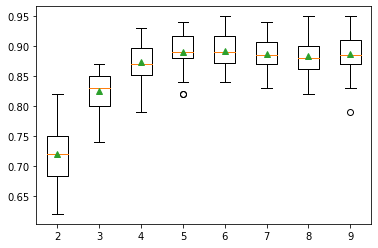

In [37]:
plt.boxplot(results, labels=names, showmeans=True);

## RFE internal algorithm

In [38]:
def get_dataset():
    X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
    return X, y
 
def get_models():
    models = dict()

    rfe = RFE(estimator=LogisticRegression(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['logi_reg'] = Pipeline(steps=[('s',rfe),('m',model)])

    rfe = RFE(estimator=Perceptron(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['perceptron'] = Pipeline(steps=[('s',rfe),('m',model)])

    rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['dec_tree'] = Pipeline(steps=[('s',rfe),('m',model)])

    rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['rand_fo'] = Pipeline(steps=[('s',rfe),('m',model)])

    rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['grad_boos'] = Pipeline(steps=[('s',rfe),('m',model)])
    return models
 
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=n_cpu)
    return scores


In [39]:
X, y = get_dataset()
models = get_models()

results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))


>logi_reg 0.891 (0.031)
>perceptron 0.845 (0.040)
>dec_tree 0.890 (0.034)
>rand_fo 0.857 (0.042)
>grad_boos 0.888 (0.032)


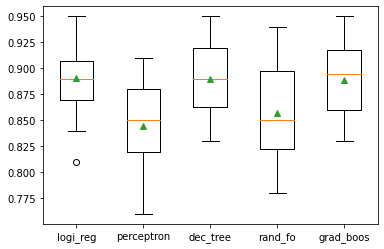

In [40]:
plt.boxplot(results, labels=names, showmeans=True)
plt.show()